

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
# ignore deprication warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# standard python modules
import os, sys
import time


# standard ml modules
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors
# work in interactive moode
%matplotlib inline 


# loading files (in parallel)
from pathlib import Path
from multiprocessing.pool import ThreadPool


# working with images
import PIL
from PIL import Image
from skimage import io

# preprocessing
from sklearn.preprocessing import LabelEncoder


# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
# torchvision
import torchvision
from torchvision import transforms


# interacrive timimg
from tqdm import tqdm, tqdm_notebook

# saving models 
import pickle
import copy

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
DEVICE

device(type='cuda')

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip -d journey-springfield

In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 28 07:12:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [8]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [9]:
class SimpsonsDataset(Dataset):
    """
    Class to work with image dastaset, which
    - loads them form the folders in parallel
    - converts to PyTorch tensors
    - scales the tensors to have mean = 0, standard deviation = 1
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files) # list of files to be loaded
        self.mode = mode           # working mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                
    
    def __len__(self):
        return self.len_
    
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
    
    
    def __getitem__(self, index):
        # converts to PyTorch tensors and normalises the input
        
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'val_test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
        }

        transform = (data_transforms['train'] if self.mode == 'train' else data_transforms['val_test'])
        
        x = self.load_sample(self.files[index])  # load image
        x = transform(x)                         # apply transform defined above
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('/content/journey-springfield/train')
TEST_DIR = Path('/content/journey-springfield/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
print(len(train_val_files), 'train files')
train_val_files[:5]

20933 train files


[PosixPath('/content/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('/content/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('/content/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('/content/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('/content/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg')]

In [13]:
print(len(test_files), 'test files')
test_files[:5]

991 test files


[PosixPath('/content/journey-springfield/testset/testset/img0.jpg'),
 PosixPath('/content/journey-springfield/testset/testset/img1.jpg'),
 PosixPath('/content/journey-springfield/testset/testset/img10.jpg'),
 PosixPath('/content/journey-springfield/testset/testset/img100.jpg'),
 PosixPath('/content/journey-springfield/testset/testset/img101.jpg')]

In [14]:
# path.parent.name returns a folder in which the image is, which corresponds to the label in nthis case
train_val_labels = [path.parent.name for path in train_val_files]

In [15]:
print(len(train_val_labels), 'train_val_labels')
train_val_labels[:5]

20933 train_val_labels


['abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson']

In [16]:
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(train_val_files, test_size=0.20, stratify=train_val_labels)

In [17]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

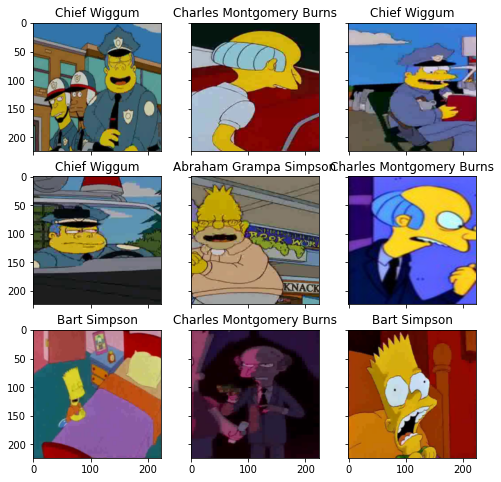

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

In [19]:
def fit_epoch(model, train_loader, criterion, optimizer):
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # reset the gradient
        optimizer.zero_grad()
        
        # predictions (probabilities), loss, backprop
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # weights update
        optimizer.step()
        
        # predictions (classes)
        preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    # record train loss and train accuracy          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [20]:
def eval_epoch(model, val_loader, criterion):
    # set model model into the evaluation mode (e.g. for Dropout)
    model.eval()
    
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    # record val loss and val accuracy
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [21]:
def train(train_dataset, val_dataset, model, criterion,
          epochs, batch_size, optimizer, scheduler,
          shuffle=True, sampler=None, patience=5):
    
    # to record the total training time
    since = time.time()
    
    # note: 4 workers loading the data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # init variables to store best model weights, best accuracy, best epoch number, epochs since best accuracy acheived
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10
    best_epoch = 0
    epochs_since_best = 0
    
    # history and log
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(1, epochs+1):
            print(f"epoch {epoch}:\n")
            
            print("Fitting on train data...")
            # all arguments except train loader are from parameters passed to train() arguments
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("train loss:", train_loss)
            
            print("Evaluating on validation data...")
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print("val loss:", val_loss)
            
            # record history
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # update learning rate for the optimizer
            scheduler.step()
            
            # display learning status
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # deep copy the model if it acheives the best validation performance
            if val_loss < best_loss:
                best_acc = val_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                print()
            else:
                epochs_since_best += 1
            
            # early stopping
            if epochs_since_best > patience:
                print(f'Stopping training. The validation metric has not improved for {patience} epochs.')
                break
            
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best epoch: {}'.format(best_epoch))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
            
    return history

In [22]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [23]:
N_CLASSES = len(np.unique(train_val_labels))

In [24]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

Training only the last layer

In [25]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b7881d9d518ab37431c3b231f22748207541fa8e0874f3d587472b07c306e144
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [26]:
from efficientnet_pytorch import EfficientNet

In [27]:
model_name = 'efficientnet-b2'

In [28]:
model = EfficientNet.from_pretrained(model_name)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


In [29]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [30]:
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, N_CLASSES)

# to GPU
model = model.to(DEVICE)

# loss
criterion = nn.CrossEntropyLoss()

# learning rate optimizer
optimizer = torch.optim.AdamW(model.parameters())

# scheduler for the lr optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

In [31]:
model._fc

Linear(in_features=1408, out_features=42, bias=True)

In [32]:
feature_extr_epochs = 3

In [33]:
history_feature_extr = train(train_dataset, val_dataset, model=model, criterion=criterion,
                             epochs=feature_extr_epochs, batch_size=256, optimizer=optimizer, scheduler=scheduler)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 2.816080071970822
Evaluating on validation data...


epoch:  33%|███▎      | 1/3 [03:32<07:04, 212.24s/it]

val loss: 2.4697439391544105

Epoch 001 train_loss: 2.8161     val_loss 2.4697 train_acc 0.3197 val_acc 0.4550

epoch 2:

Fitting on train data...
train loss: 2.0353817675655552
Evaluating on validation data...


epoch:  67%|██████▋   | 2/3 [07:05<03:32, 212.87s/it]

val loss: 1.7548837868444727

Epoch 002 train_loss: 2.0354     val_loss 1.7549 train_acc 0.5463 val_acc 0.6124

epoch 3:

Fitting on train data...
train loss: 1.5977416844631656
Evaluating on validation data...


epoch: 100%|██████████| 3/3 [10:44<00:00, 214.98s/it]

val loss: 1.486225349851289

Epoch 003 train_loss: 1.5977     val_loss 1.4862 train_acc 0.6273 val_acc 0.6599

Training complete in 10m 45s
Best val loss: 10.000000
Best epoch: 3


In [34]:
loss, acc, val_loss, val_acc = zip(*history_feature_extr)

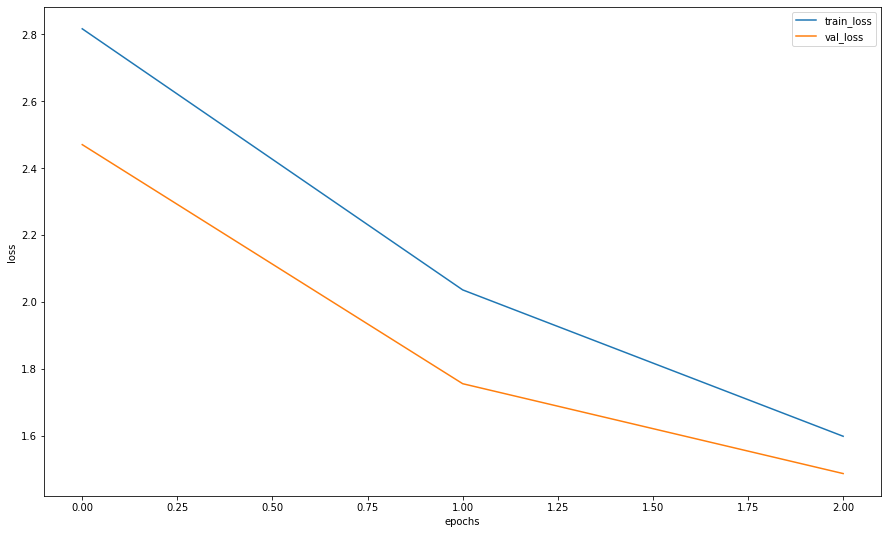

In [35]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Training all layers

In [36]:
for param in model.parameters():
    param.requires_grad = True

In [37]:
finetuning_epochs = 20

In [38]:
history_fine_tune = train(train_dataset=train_dataset, val_dataset=val_dataset, model=model, criterion=criterion,
                          epochs=finetuning_epochs, batch_size=16, optimizer=optimizer, scheduler=scheduler)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 0.4610751473526055
Evaluating on validation data...


epoch:   5%|▌         | 1/20 [07:39<2:25:36, 459.83s/it]

val loss: 0.1900292584273099

Epoch 001 train_loss: 0.4611     val_loss 0.1900 train_acc 0.8803 val_acc 0.9520

epoch 2:

Fitting on train data...
train loss: 0.227955534666559
Evaluating on validation data...


epoch:  10%|█         | 2/20 [15:20<2:18:04, 460.23s/it]

val loss: 0.16228132652883298

Epoch 002 train_loss: 0.2280     val_loss 0.1623 train_acc 0.9402 val_acc 0.9577

epoch 3:

Fitting on train data...
train loss: 0.19532413977905666
Evaluating on validation data...


epoch:  15%|█▌        | 3/20 [23:00<2:10:24, 460.27s/it]

val loss: 0.1761299595274226

Epoch 003 train_loss: 0.1953     val_loss 0.1761 train_acc 0.9483 val_acc 0.9570

epoch 4:

Fitting on train data...
train loss: 0.07108287800511714
Evaluating on validation data...


epoch:  20%|██        | 4/20 [30:40<2:02:44, 460.27s/it]

val loss: 0.10210113575921802

Epoch 004 train_loss: 0.0711     val_loss 0.1021 train_acc 0.9827 val_acc 0.9756

epoch 5:

Fitting on train data...
train loss: 0.05060067677520271
Evaluating on validation data...


epoch:  25%|██▌       | 5/20 [38:21<1:55:05, 460.37s/it]

val loss: 0.15314130060279219

Epoch 005 train_loss: 0.0506     val_loss 0.1531 train_acc 0.9870 val_acc 0.9644

epoch 6:

Fitting on train data...
train loss: 0.07118963005940708
Evaluating on validation data...


epoch:  30%|███       | 6/20 [46:00<1:47:19, 459.96s/it]

val loss: 0.13715436592300906

Epoch 006 train_loss: 0.0712     val_loss 0.1372 train_acc 0.9799 val_acc 0.9721

epoch 7:

Fitting on train data...
train loss: 0.026447868465507555
Evaluating on validation data...


epoch:  35%|███▌      | 7/20 [53:39<1:39:35, 459.68s/it]

val loss: 0.07667960345708931

Epoch 007 train_loss: 0.0264     val_loss 0.0767 train_acc 0.9934 val_acc 0.9830

epoch 8:

Fitting on train data...


epoch:  35%|███▌      | 7/20 [59:08<1:49:50, 506.96s/it]


KeyboardInterrupt: ignored

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_fine_tune)

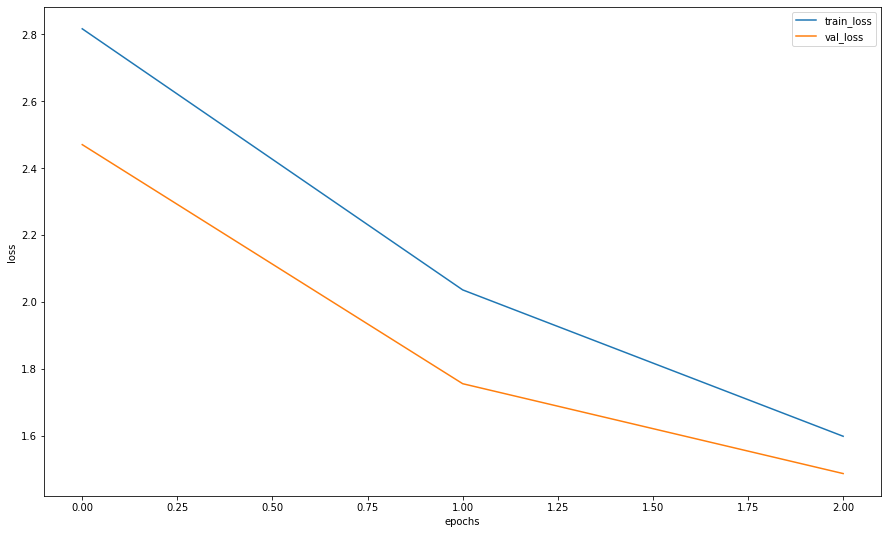

In [40]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")


plt.savefig(f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-LearningCurve.png")
plt.show()

In [41]:
f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-LearningCurve.png"

'efficientnet-b2_3FeatureExtrEpochs-20FinetuningEpochs-LearningCurve.png'

In [42]:
# save the weights of our net
model_weights = copy.deepcopy(model.state_dict())
torch.save(model_weights, f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-weights.pth")

In [43]:
%ls

efficientnet-b2_3FeatureExtrEpochs-20FinetuningEpochs-LearningCurve.png
efficientnet-b2_3FeatureExtrEpochs-20FinetuningEpochs-weights.pth
gdrive/
journey-springfield/
label_encoder.pkl
sample_data/


In [44]:
# загружаем сохраненное состояние весов нейросети
model.load_state_dict(torch.load(f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-weights.pth"))

<All keys matched successfully>

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [45]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [47]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [48]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [49]:
actual_labels = [val_dataset[id][1] for id in idxs]
actual_labels

[4, 6, 0, 4, 6, 7, 4, 0, 0, 6, 4, 1, 6, 4, 6, 6, 0, 6, 6, 4]

In [50]:
y_pred = np.argmax(probs_ims, -1)
y_pred

array([4, 6, 0, 4, 6, 7, 4, 0, 0, 6, 4, 1, 6, 4, 6, 6, 0, 6, 6, 4])

In [52]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [53]:
actual_class = [label_encoder.classes_[i] for i in actual_labels]
actual_class

['bart_simpson',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'bart_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'bart_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'bart_simpson',
 'agnes_skinner',
 'charles_montgomery_burns',
 'bart_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'bart_simpson']

In [54]:
preds_class = [label_encoder.classes_[i] for i in y_pred]
preds_class

['bart_simpson',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'bart_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'bart_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'bart_simpson',
 'agnes_skinner',
 'charles_montgomery_burns',
 'bart_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'bart_simpson']

In [55]:
from sklearn.metrics import f1_score

f1_score(actual_class, preds_class, average='weighted')

1.0

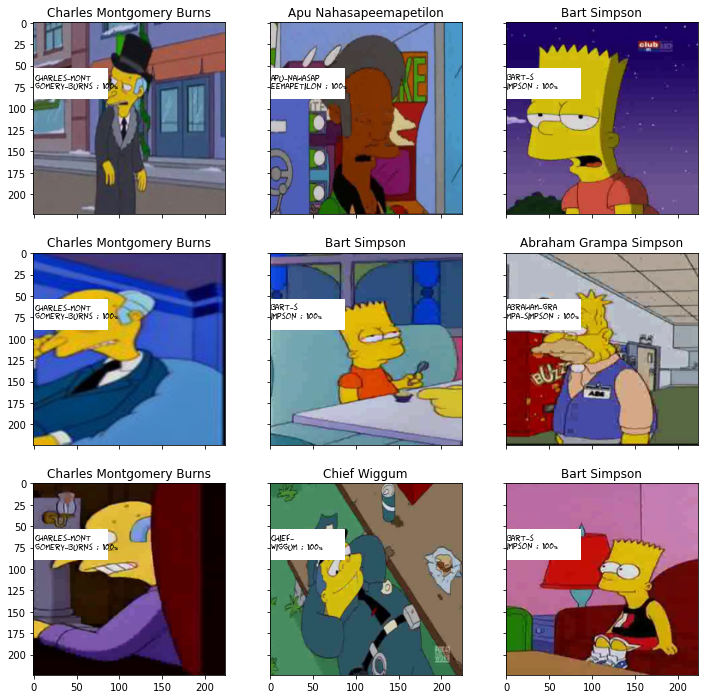

In [56]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [57]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=4)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [58]:
! ls 

efficientnet-b2_3FeatureExtrEpochs-20FinetuningEpochs-LearningCurve.png
efficientnet-b2_3FeatureExtrEpochs-20FinetuningEpochs-weights.pth
gdrive
journey-springfield
label_encoder.pkl
sample_data


In [59]:
import pandas as pd
sample_submit = pd.read_csv("/content/journey-springfield/sample_submission.csv")
sample_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [60]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
print(my_submit.shape)
my_submit.head()

(991, 2)


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [65]:
my_submit.to_csv(f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}submission.csv", index=False)

In [66]:
f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-submission.csv"

'efficientnet-b2_3FeatureExtrEpochs-20FinetuningEpochs-submission.csv'

In [63]:
f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-weights.pth"
f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-LearningCurve.png"
f"{model_name}_{feature_extr_epochs}FeatureExtrEpochs-{finetuning_epochs}FinetuningEpochs-submission.csv"

'efficientnet-b2_3FeatureExtrEpochs-20FinetuningEpochs-submission.csv'